## Attention Only Analysis

In [1]:
from __future__ import print_function
import keras
from keras import backend as K

Using TensorFlow backend.


In [2]:
import tensorflow as tf

In [3]:
import os
import numpy as np
import Bio
from Bio import SeqIO
import seaborn as sns
import pandas as pd
import Bio.motifs
%matplotlib inline
from sklearn import model_selection
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import scipy
sns.set_context('notebook')

In [4]:
%load_ext autoreload
%autoreload 2

In [9]:
# if not os.path.isdir('/home/jtao/analysis/genomic_grammar_analysis/'):
#     os.mkdir('/home/jtao/analysis/genomic_grammar_analysis')
# os.chdir('/home/jtao/analysis/genomic_grammar_analysis')
working_directory = '/home/jtao/analysis/genomic_grammar_analysis/'

In [14]:
from signal_models import *

## Functions

In [15]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''

    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0.25,0.25,0.25,0.25]}

    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array, dtype=np.float16)
        sequence_array_list.append(seq_array)
    sequence_array_list = np.array(sequence_array_list,dtype=np.float16)
    return sequence_array_list

In [16]:
def quantile_normalize_df(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

In [18]:
# positive_seqRecords = list(SeqIO.parse(working_directory + '/peak_sequences/c57bl6_kla-1h_peaks.fasta', 'fasta'))
# negative_seqRecords = list(SeqIO.parse(working_directory + '/background_files/c57bl6_kla-1h_background.fasta', 'fasta'))[:len(positive_seqRecords)]

positive_seqRecords = list(SeqIO.parse(working_directory + '/peak_sequences/c57bl6_il4-24h_peaks.fasta', 'fasta'))
negative_seqRecords = list(SeqIO.parse(working_directory + './background_files/c57bl6_il4-24h_background.fasta', 'fasta'))[:len(positive_seqRecords)]
fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
    [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

sequence_arrays = convert_sequences_to_array(fasta_seq)

sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)


labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
labels = np.array(labels)

x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Additive Attention

In [60]:
additiveAttention_model = get_additiveAttention_model(200,
    mode='classification',
    num_motifs=150, 
    motif_size=10,
    adjacent_bp_pool_size=10,
    attention_dim=10,
    attention_hops=10,
    dropout_rate=0.1
    )
additiveAttention_model.count_params()

10752

In [61]:
additiveAttention_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_fwd (InputLayer)          (None, 200, 4)       0                                            
__________________________________________________________________________________________________
convolution_layer (Conv1D)      (None, 200, 150)     6150        input_fwd[0][0]                  
__________________________________________________________________________________________________
attention_tanh_layer (Dense)    (None, 200, 10)      1500        convolution_layer[0][0]          
__________________________________________________________________________________________________
attention_outer_layer (Dense)   (None, 200, 10)      100         attention_tanh_layer[0][0]       
__________________________________________________________________________________________________
attention_

In [63]:
additiveAttention_model.fit([x_train], y_train,
              batch_size=64,
              epochs=10,
              verbose=1,
              validation_data=([x_test], y_test))

probs = additiveAttention_model.predict([x_test])

roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
acc = additiveAttention_model.evaluate([x_test], y_test, verbose=0)[1]
print(roc, precision, acc)

Train on 53628 samples, validate on 13408 samples
Epoch 1/10
53628/53628 [==============================] - 17s 315us/step - loss: 0.3453 - categorical_accuracy: 0.8504 - val_loss: 0.3707 - val_categorical_accuracy: 0.8341
Epoch 2/10
53628/53628 [==============================] - 17s 312us/step - loss: 0.3410 - categorical_accuracy: 0.8521 - val_loss: 0.3697 - val_categorical_accuracy: 0.8367
Epoch 3/10
53628/53628 [==============================] - 17s 314us/step - loss: 0.3335 - categorical_accuracy: 0.8564 - val_loss: 0.3622 - val_categorical_accuracy: 0.8387
Epoch 4/10
53628/53628 [==============================] - 17s 316us/step - loss: 0.3317 - categorical_accuracy: 0.8567 - val_loss: 0.3468 - val_categorical_accuracy: 0.8479
Epoch 5/10
53628/53628 [==============================] - 17s 314us/step - loss: 0.3247 - categorical_accuracy: 0.8590 - val_loss: 0.3431 - val_categorical_accuracy: 0.8487
Epoch 6/10
53628/53628 [==============================] - 17s 313us/step - loss: 0.32

## Dot Product Attention

In [64]:
dotProductAttention_model = get_dotProductAttention_model(200,
    mode='classification',
    num_motifs=150, 
    motif_size=10,
    adjacent_bp_pool_size=10,
    dropout_rate=0.1,
    num_classes=2)

In [65]:
# SVG(model_to_dot(dotProductAttention_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [66]:
dotProductAttention_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_fwd (InputLayer)          (None, 200, 4)       0                                            
__________________________________________________________________________________________________
convolution_layer (Conv1D)      (None, 200, 150)     6150        input_fwd[0][0]                  
__________________________________________________________________________________________________
sequence_pooling_layer (MaxPool (None, 20, 150)      0           convolution_layer[0][0]          
__________________________________________________________________________________________________
query_transformer (TimeDistribu (None, 20, 150)      150         sequence_pooling_layer[0][0]     
__________________________________________________________________________________________________
key_transf

In [67]:
dotProductAttention_model.count_params()

12602

In [69]:
dotProductAttention_model.fit([x_train], y_train,
              batch_size=64,
              epochs=10,
              verbose=1,
              validation_data=([x_test], y_test))

probs = dotProductAttention_model.predict([x_test])

roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
acc = dotProductAttention_model.evaluate([x_test], y_test, verbose=0)[1]
print(roc, precision, acc)

Train on 53628 samples, validate on 13408 samples
Epoch 1/10
53628/53628 [==============================] - 13s 238us/step - loss: 0.3300 - categorical_accuracy: 0.8556 - val_loss: 0.3410 - val_categorical_accuracy: 0.8506
Epoch 2/10
53628/53628 [==============================] - 13s 236us/step - loss: 0.3224 - categorical_accuracy: 0.8591 - val_loss: 0.3365 - val_categorical_accuracy: 0.8536
Epoch 3/10
53628/53628 [==============================] - 13s 236us/step - loss: 0.3151 - categorical_accuracy: 0.8646 - val_loss: 0.3341 - val_categorical_accuracy: 0.8540
Epoch 4/10
53628/53628 [==============================] - 13s 238us/step - loss: 0.3112 - categorical_accuracy: 0.8657 - val_loss: 0.3302 - val_categorical_accuracy: 0.8559
Epoch 5/10
53628/53628 [==============================] - 13s 237us/step - loss: 0.3019 - categorical_accuracy: 0.8712 - val_loss: 0.3335 - val_categorical_accuracy: 0.8560
Epoch 6/10
53628/53628 [==============================] - 13s 238us/step - loss: 0.29

## Convolution

In [70]:
convolution_model = get_convolution_model(200,
    mode='classification',
    num_motifs=150, 
    motif_size=10,
    num_dense_neurons=50,
    dropout_rate=0.1,
    num_classes=2)

In [71]:
# SVG(model_to_dot(dotProductAttention_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [72]:
convolution_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_fwd (InputLayer)          (None, 200, 4)       0                                            
__________________________________________________________________________________________________
input_rev (InputLayer)          (None, 200, 4)       0                                            
__________________________________________________________________________________________________
convolution_layer (Conv1D)      (None, 200, 150)     6150        input_fwd[0][0]                  
                                                                 input_rev[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 1, 150)       0           convolution_layer[0][0]          
          

In [73]:
convolution_model.count_params()

13802

In [ ]:
convolution_model.fit([x_train, x_rc_train], y_train,
              batch_size=64,
              epochs=10,
              verbose=1,
              validation_data=([x_test, x_rc_test], y_test))

probs = convolution_model.predict([x_test, x_rc_test])

roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
acc = convolution_model.evaluate([x_test, x_rc_test], y_test, verbose=0)[1]
print(roc, precision, acc)

Train on 53628 samples, validate on 13408 samples
Epoch 1/10
53628/53628 [==============================] - 13s 237us/step - loss: 0.4904 - categorical_accuracy: 0.7512 - val_loss: 0.3668 - val_categorical_accuracy: 0.8392
Epoch 2/10
53628/53628 [==============================] - 12s 229us/step - loss: 0.3635 - categorical_accuracy: 0.8393 - val_loss: 0.3460 - val_categorical_accuracy: 0.8472
Epoch 3/10
53628/53628 [==============================] - 12s 230us/step - loss: 0.3391 - categorical_accuracy: 0.8526 - val_loss: 0.3488 - val_categorical_accuracy: 0.8446
Epoch 4/10
53628/53628 [==============================] - 12s 231us/step - loss: 0.3216 - categorical_accuracy: 0.8631 - val_loss: 0.3538 - val_categorical_accuracy: 0.8405
Epoch 5/10
53628/53628 [==============================] - 12s 231us/step - loss: 0.3081 - categorical_accuracy: 0.8684 - val_loss: 0.3414 - val_categorical_accuracy: 0.8521
Epoch 6/10
53628/53628 [==============================] - 12s 231us/step - loss: 0.30

## Grid Search

In [ ]:
all_rocs = []
all_accuracies = []
all_precisions = []
poolSize_list = []
all_treatments = []
motifCount_list = []
numDense_list = []
paramCount_list = []
dropoutRate_list = []
for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    print(ps)
    positive_seqRecords = list(SeqIO.parse('./peak_sequences/' + ps, 'fasta'))
    negative_seqRecords = list(SeqIO.parse('./background_files/' + ps.replace('_peaks', '_background'), 'fasta'))[:len(positive_seqRecords)]

    fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

    fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
        [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

    sequence_arrays = convert_sequences_to_array(fasta_seq)

    sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)


    labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
    labels = np.array(labels)

    x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

    num_classes = 2
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    treatment = ps.split('_')[1]
    
    for d in range(50,200,50):
        for m in range(50,200,50):
            for p in [5,10,20]:
                for do in [0.25,0.5,0.75]:
                    
                    current_model = get_dotProductAttention_model(200,
                        seq_size=150,
                        num_motifs=m, 
                        motif_size=10,
                        adjacent_bp_pool_size=p,
                        num_dense_neurons=d,
                        dropout_rate=do)
                    num_params = current_model.count_params()
                    print(treatment, 
                         'num dense', d,
                         'num motifs', m,
                         'pool size', p,
                         'dropout rate', do,
                         'param count', num_params)
                    current_model.fit([x_train, x_rc_train], y_train,
                          batch_size=64,
                          epochs=20,
                          verbose=1,
                          validation_data=([x_test, x_rc_test], y_test))

                    probs = current_model.predict([x_test, x_rc_test])

                    roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
                    precision = sklearn.metrics.precision_score([y[1] for y in y_test], [1 if x > 0.5 else 0 for x in probs[:,1]])
                    acc = current_model.evaluate([x_test, x_rc_test], y_test, verbose=0)[1]

                    
                    
                    
                    

                    all_rocs.append(roc)
                    all_accuracies.append(acc)
                    all_precisions.append(precision)
                    poolSize_list.append(p)
                    all_treatments.append(treatment)
                    motifCount_list.append(m)
                    numDense_list.append(d)
                    paramCount_list.append(num_params)
                    dropoutRate_list.append(do)

c57bl6_kla-1h_peaks.fasta
kla-1h num dense 50 num motifs 50 pool size 5 dropout rate 0.25 param count 10402
Train on 34841 samples, validate on 8711 samples
Epoch 1/20
34841/34841 [==============================] - 17s 479us/step - loss: 0.6759 - acc: 0.5573 - val_loss: 0.6470 - val_acc: 0.6178
Epoch 2/20
34841/34841 [==============================] - 13s 378us/step - loss: 0.6044 - acc: 0.6719 - val_loss: 0.6077 - val_acc: 0.6661
Epoch 3/20
34841/34841 [==============================] - 13s 368us/step - loss: 0.5516 - acc: 0.7190 - val_loss: 0.5445 - val_acc: 0.7255
Epoch 4/20
34841/34841 [==============================] - 13s 375us/step - loss: 0.5183 - acc: 0.7455 - val_loss: 0.5316 - val_acc: 0.7336
Epoch 5/20
34841/34841 [==============================] - 13s 372us/step - loss: 0.4985 - acc: 0.7570 - val_loss: 0.5049 - val_acc: 0.7518
Epoch 6/20
34841/34841 [==============================] - 13s 370us/step - loss: 0.4803 - acc: 0.7700 - val_loss: 0.5050 - val_acc: 0.7526
Epoch 7/2

Epoch 17/20
34841/34841 [==============================] - 12s 353us/step - loss: 0.3741 - acc: 0.8337 - val_loss: 0.4168 - val_acc: 0.8153
Epoch 18/20
34841/34841 [==============================] - 12s 344us/step - loss: 0.3724 - acc: 0.8358 - val_loss: 0.4158 - val_acc: 0.8101
Epoch 19/20
34841/34841 [==============================] - 12s 348us/step - loss: 0.3680 - acc: 0.8352 - val_loss: 0.4059 - val_acc: 0.8158
Epoch 20/20
34841/34841 [==============================] - 12s 349us/step - loss: 0.3634 - acc: 0.8411 - val_loss: 0.4120 - val_acc: 0.8127
kla-1h num dense 50 num motifs 50 pool size 10 dropout rate 0.25 param count 8902
Train on 34841 samples, validate on 8711 samples
Epoch 1/20
34841/34841 [==============================] - 11s 326us/step - loss: 0.6737 - acc: 0.5666 - val_loss: 0.6270 - val_acc: 0.6539
Epoch 2/20
34841/34841 [==============================] - 11s 310us/step - loss: 0.5712 - acc: 0.7008 - val_loss: 0.5300 - val_acc: 0.7367
Epoch 3/20
34841/34841 [=======

Epoch 13/20
34841/34841 [==============================] - 11s 309us/step - loss: 0.3829 - acc: 0.8294 - val_loss: 0.4202 - val_acc: 0.8078
Epoch 14/20
34841/34841 [==============================] - 11s 308us/step - loss: 0.3764 - acc: 0.8325 - val_loss: 0.4148 - val_acc: 0.8110
Epoch 15/20
34841/34841 [==============================] - 11s 311us/step - loss: 0.3739 - acc: 0.8322 - val_loss: 0.4109 - val_acc: 0.8147
Epoch 16/20
34841/34841 [==============================] - 11s 316us/step - loss: 0.3685 - acc: 0.8383 - val_loss: 0.4078 - val_acc: 0.8109
Epoch 17/20
34841/34841 [==============================] - 11s 311us/step - loss: 0.3645 - acc: 0.8402 - val_loss: 0.4219 - val_acc: 0.8112
Epoch 18/20
34841/34841 [==============================] - 11s 312us/step - loss: 0.3642 - acc: 0.8404 - val_loss: 0.4049 - val_acc: 0.8154
Epoch 19/20
34841/34841 [==============================] - 11s 315us/step - loss: 0.3616 - acc: 0.8419 - val_loss: 0.4240 - val_acc: 0.8039
Epoch 20/20
34841/34

Epoch 9/20
34841/34841 [==============================] - 10s 301us/step - loss: 0.4168 - acc: 0.8112 - val_loss: 0.4521 - val_acc: 0.7883
Epoch 10/20
34841/34841 [==============================] - 10s 298us/step - loss: 0.4117 - acc: 0.8120 - val_loss: 0.4375 - val_acc: 0.7963
Epoch 11/20
34841/34841 [==============================] - 10s 299us/step - loss: 0.4059 - acc: 0.8181 - val_loss: 0.4527 - val_acc: 0.7928
Epoch 12/20
34841/34841 [==============================] - 11s 304us/step - loss: 0.4015 - acc: 0.8200 - val_loss: 0.4499 - val_acc: 0.7921
Epoch 13/20
34841/34841 [==============================] - 10s 298us/step - loss: 0.3975 - acc: 0.8241 - val_loss: 0.4369 - val_acc: 0.7972
Epoch 14/20
34841/34841 [==============================] - 10s 292us/step - loss: 0.3924 - acc: 0.8268 - val_loss: 0.4489 - val_acc: 0.7882
Epoch 15/20
34841/34841 [==============================] - 10s 297us/step - loss: 0.3903 - acc: 0.8262 - val_loss: 0.4362 - val_acc: 0.7970
Epoch 16/20
34841/348

Epoch 5/20
34841/34841 [==============================] - 16s 465us/step - loss: 0.4907 - acc: 0.7627 - val_loss: 0.4848 - val_acc: 0.7658
Epoch 6/20
34841/34841 [==============================] - 16s 463us/step - loss: 0.4480 - acc: 0.7911 - val_loss: 0.4546 - val_acc: 0.7821
Epoch 7/20
34841/34841 [==============================] - 16s 460us/step - loss: 0.4128 - acc: 0.8133 - val_loss: 0.4185 - val_acc: 0.8066
Epoch 8/20
34841/34841 [==============================] - 16s 461us/step - loss: 0.3958 - acc: 0.8211 - val_loss: 0.4055 - val_acc: 0.8154
Epoch 9/20
34841/34841 [==============================] - 16s 460us/step - loss: 0.3749 - acc: 0.8334 - val_loss: 0.3961 - val_acc: 0.8248
Epoch 10/20
34841/34841 [==============================] - 16s 458us/step - loss: 0.3647 - acc: 0.8392 - val_loss: 0.3921 - val_acc: 0.8231
Epoch 11/20
34841/34841 [==============================] - 16s 457us/step - loss: 0.3549 - acc: 0.8455 - val_loss: 0.3896 - val_acc: 0.8296
Epoch 12/20
34841/34841 [

34841/34841 [==============================] - 15s 440us/step - loss: 0.6800 - acc: 0.5452 - val_loss: 0.6379 - val_acc: 0.6346
Epoch 2/20
34841/34841 [==============================] - 14s 413us/step - loss: 0.5953 - acc: 0.6809 - val_loss: 0.5396 - val_acc: 0.7300
Epoch 3/20
34841/34841 [==============================] - 14s 407us/step - loss: 0.5151 - acc: 0.7473 - val_loss: 0.4820 - val_acc: 0.7702
Epoch 4/20
34841/34841 [==============================] - 14s 407us/step - loss: 0.4600 - acc: 0.7856 - val_loss: 0.4448 - val_acc: 0.7911
Epoch 5/20
34841/34841 [==============================] - 14s 406us/step - loss: 0.4234 - acc: 0.8049 - val_loss: 0.4237 - val_acc: 0.8069
Epoch 6/20
34841/34841 [==============================] - 14s 404us/step - loss: 0.4019 - acc: 0.8177 - val_loss: 0.4213 - val_acc: 0.8075
Epoch 7/20
34841/34841 [==============================] - 14s 407us/step - loss: 0.3822 - acc: 0.8286 - val_loss: 0.4028 - val_acc: 0.8183
Epoch 8/20
34841/34841 [==============

Epoch 18/20
34841/34841 [==============================] - 13s 377us/step - loss: 0.3101 - acc: 0.8669 - val_loss: 0.3963 - val_acc: 0.8214
Epoch 19/20
34841/34841 [==============================] - 13s 378us/step - loss: 0.3086 - acc: 0.8676 - val_loss: 0.3920 - val_acc: 0.8240
Epoch 20/20
34841/34841 [==============================] - 13s 377us/step - loss: 0.3046 - acc: 0.8707 - val_loss: 0.3998 - val_acc: 0.8253
kla-1h num dense 50 num motifs 100 pool size 20 dropout rate 0.75 param count 15452
Train on 34841 samples, validate on 8711 samples
Epoch 1/20
34841/34841 [==============================] - 14s 410us/step - loss: 0.6929 - acc: 0.5082 - val_loss: 0.6845 - val_acc: 0.5977
Epoch 2/20
34841/34841 [==============================] - 13s 381us/step - loss: 0.6121 - acc: 0.6650 - val_loss: 0.5594 - val_acc: 0.7115
Epoch 3/20
34841/34841 [==============================] - 13s 376us/step - loss: 0.5133 - acc: 0.7533 - val_loss: 0.4788 - val_acc: 0.7704
Epoch 4/20
34841/34841 [======

Epoch 14/20
34841/34841 [==============================] - 25s 722us/step - loss: 0.3038 - acc: 0.8691 - val_loss: 0.3910 - val_acc: 0.8341
Epoch 15/20
34841/34841 [==============================] - 25s 728us/step - loss: 0.2960 - acc: 0.8736 - val_loss: 0.4127 - val_acc: 0.8250
Epoch 16/20
34841/34841 [==============================] - 25s 722us/step - loss: 0.2929 - acc: 0.8753 - val_loss: 0.4083 - val_acc: 0.8284
Epoch 17/20
34841/34841 [==============================] - 25s 724us/step - loss: 0.2868 - acc: 0.8765 - val_loss: 0.4005 - val_acc: 0.8323
Epoch 18/20
34841/34841 [==============================] - 25s 723us/step - loss: 0.2827 - acc: 0.8800 - val_loss: 0.3968 - val_acc: 0.8330
Epoch 19/20
34841/34841 [==============================] - 25s 713us/step - loss: 0.2781 - acc: 0.8819 - val_loss: 0.3994 - val_acc: 0.8309
Epoch 20/20
34841/34841 [==============================] - 25s 718us/step - loss: 0.2742 - acc: 0.8830 - val_loss: 0.3988 - val_acc: 0.8300
kla-1h num dense 50 

Epoch 10/20
34841/34841 [==============================] - 20s 572us/step - loss: 0.3155 - acc: 0.8643 - val_loss: 0.3926 - val_acc: 0.8246
Epoch 11/20
34841/34841 [==============================] - 20s 567us/step - loss: 0.3059 - acc: 0.8711 - val_loss: 0.3805 - val_acc: 0.8350
Epoch 12/20
34841/34841 [==============================] - 20s 568us/step - loss: 0.3033 - acc: 0.8696 - val_loss: 0.3912 - val_acc: 0.8287
Epoch 13/20
34841/34841 [==============================] - 20s 569us/step - loss: 0.2946 - acc: 0.8760 - val_loss: 0.3762 - val_acc: 0.8323
Epoch 14/20
34841/34841 [==============================] - 20s 572us/step - loss: 0.2882 - acc: 0.8787 - val_loss: 0.3838 - val_acc: 0.8386
Epoch 15/20
34841/34841 [==============================] - 20s 571us/step - loss: 0.2834 - acc: 0.8797 - val_loss: 0.4080 - val_acc: 0.8224
Epoch 16/20
34841/34841 [==============================] - 20s 571us/step - loss: 0.2775 - acc: 0.8843 - val_loss: 0.3981 - val_acc: 0.8279
Epoch 17/20
34841/34

Epoch 6/20
34841/34841 [==============================] - 18s 526us/step - loss: 0.3692 - acc: 0.8365 - val_loss: 0.4265 - val_acc: 0.8074
Epoch 7/20
34841/34841 [==============================] - 19s 531us/step - loss: 0.3564 - acc: 0.8446 - val_loss: 0.4234 - val_acc: 0.8114
Epoch 8/20
34841/34841 [==============================] - 18s 527us/step - loss: 0.3482 - acc: 0.8499 - val_loss: 0.4301 - val_acc: 0.8043
Epoch 9/20
34841/34841 [==============================] - 19s 531us/step - loss: 0.3412 - acc: 0.8528 - val_loss: 0.4117 - val_acc: 0.8152
Epoch 10/20
34841/34841 [==============================] - 18s 527us/step - loss: 0.3300 - acc: 0.8594 - val_loss: 0.4118 - val_acc: 0.8174
Epoch 11/20
34841/34841 [==============================] - 19s 534us/step - loss: 0.3219 - acc: 0.8644 - val_loss: 0.4130 - val_acc: 0.8175
Epoch 12/20
34841/34841 [==============================] - 18s 529us/step - loss: 0.3140 - acc: 0.8665 - val_loss: 0.4158 - val_acc: 0.8199
Epoch 13/20
34841/34841 

Epoch 2/20
34841/34841 [==============================] - 12s 357us/step - loss: 0.6189 - acc: 0.6570 - val_loss: 0.5899 - val_acc: 0.6834
Epoch 3/20
34841/34841 [==============================] - 12s 352us/step - loss: 0.5457 - acc: 0.7261 - val_loss: 0.5111 - val_acc: 0.7540
Epoch 4/20
34841/34841 [==============================] - 12s 352us/step - loss: 0.4918 - acc: 0.7633 - val_loss: 0.4785 - val_acc: 0.7747
Epoch 5/20
34841/34841 [==============================] - 12s 356us/step - loss: 0.4589 - acc: 0.7862 - val_loss: 0.4647 - val_acc: 0.7789
Epoch 6/20
34841/34841 [==============================] - 12s 354us/step - loss: 0.4392 - acc: 0.7978 - val_loss: 0.4599 - val_acc: 0.7782
Epoch 7/20
34841/34841 [==============================] - 12s 354us/step - loss: 0.4221 - acc: 0.8087 - val_loss: 0.4380 - val_acc: 0.7945
Epoch 8/20
34841/34841 [==============================] - 12s 351us/step - loss: 0.4105 - acc: 0.8121 - val_loss: 0.4507 - val_acc: 0.7888
Epoch 9/20
34841/34841 [===

Epoch 19/20
34841/34841 [==============================] - 11s 311us/step - loss: 0.3267 - acc: 0.8595 - val_loss: 0.4036 - val_acc: 0.8221
Epoch 20/20
34841/34841 [==============================] - 11s 314us/step - loss: 0.3284 - acc: 0.8572 - val_loss: 0.3896 - val_acc: 0.8299
kla-1h num dense 100 num motifs 50 pool size 10 dropout rate 0.5 param count 15452
Train on 34841 samples, validate on 8711 samples
Epoch 1/20
34841/34841 [==============================] - 13s 368us/step - loss: 0.6661 - acc: 0.5714 - val_loss: 0.6082 - val_acc: 0.6750
Epoch 2/20
34841/34841 [==============================] - 11s 312us/step - loss: 0.5590 - acc: 0.7140 - val_loss: 0.5241 - val_acc: 0.7392
Epoch 3/20
34841/34841 [==============================] - 11s 313us/step - loss: 0.4978 - acc: 0.7607 - val_loss: 0.4791 - val_acc: 0.7685
Epoch 4/20
34841/34841 [==============================] - 11s 312us/step - loss: 0.4672 - acc: 0.7786 - val_loss: 0.4720 - val_acc: 0.7733
Epoch 5/20
34841/34841 [========

Epoch 15/20
34841/34841 [==============================] - 10s 297us/step - loss: 0.3563 - acc: 0.8423 - val_loss: 0.4273 - val_acc: 0.8052
Epoch 16/20
34841/34841 [==============================] - 10s 296us/step - loss: 0.3499 - acc: 0.8449 - val_loss: 0.4016 - val_acc: 0.8188
Epoch 17/20
34841/34841 [==============================] - 10s 297us/step - loss: 0.3475 - acc: 0.8466 - val_loss: 0.3953 - val_acc: 0.8188
Epoch 18/20
34841/34841 [==============================] - 10s 300us/step - loss: 0.3449 - acc: 0.8475 - val_loss: 0.4230 - val_acc: 0.8155
Epoch 19/20
34841/34841 [==============================] - 10s 299us/step - loss: 0.3449 - acc: 0.8463 - val_loss: 0.3990 - val_acc: 0.8223
Epoch 20/20
34841/34841 [==============================] - 10s 295us/step - loss: 0.3381 - acc: 0.8508 - val_loss: 0.3979 - val_acc: 0.8240
kla-1h num dense 100 num motifs 50 pool size 20 dropout rate 0.5 param count 13852
Train on 34841 samples, validate on 8711 samples
Epoch 1/20
34841/34841 [====

Epoch 11/20
34841/34841 [==============================] - 17s 492us/step - loss: 0.3313 - acc: 0.8564 - val_loss: 0.3918 - val_acc: 0.8247
Epoch 12/20
34841/34841 [==============================] - 17s 492us/step - loss: 0.3225 - acc: 0.8614 - val_loss: 0.4008 - val_acc: 0.8230
Epoch 13/20
34841/34841 [==============================] - 17s 489us/step - loss: 0.3208 - acc: 0.8591 - val_loss: 0.3906 - val_acc: 0.8237
Epoch 14/20
34841/34841 [==============================] - 17s 490us/step - loss: 0.3147 - acc: 0.8641 - val_loss: 0.4149 - val_acc: 0.8161
Epoch 15/20
34841/34841 [==============================] - 17s 487us/step - loss: 0.3074 - acc: 0.8657 - val_loss: 0.4038 - val_acc: 0.8216
Epoch 16/20
34841/34841 [==============================] - 17s 492us/step - loss: 0.3082 - acc: 0.8676 - val_loss: 0.3910 - val_acc: 0.8300
Epoch 17/20
34841/34841 [==============================] - 17s 491us/step - loss: 0.2998 - acc: 0.8716 - val_loss: 0.3960 - val_acc: 0.8246
Epoch 18/20
34841/34

Epoch 7/20
34841/34841 [==============================] - 15s 435us/step - loss: 0.3483 - acc: 0.8475 - val_loss: 0.3818 - val_acc: 0.8309
Epoch 8/20
34841/34841 [==============================] - 15s 434us/step - loss: 0.3357 - acc: 0.8517 - val_loss: 0.3868 - val_acc: 0.8333
Epoch 9/20
34841/34841 [==============================] - 15s 433us/step - loss: 0.3254 - acc: 0.8589 - val_loss: 0.3729 - val_acc: 0.8350
Epoch 10/20
34841/34841 [==============================] - 15s 442us/step - loss: 0.3172 - acc: 0.8636 - val_loss: 0.3746 - val_acc: 0.8372
Epoch 11/20
34841/34841 [==============================] - 15s 440us/step - loss: 0.3121 - acc: 0.8656 - val_loss: 0.3758 - val_acc: 0.8397
Epoch 12/20
34841/34841 [==============================] - 15s 439us/step - loss: 0.3047 - acc: 0.8701 - val_loss: 0.3786 - val_acc: 0.8391
Epoch 13/20
34841/34841 [==============================] - 15s 441us/step - loss: 0.3000 - acc: 0.8717 - val_loss: 0.3763 - val_acc: 0.8350
Epoch 14/20
34841/34841

Epoch 3/20
34841/34841 [==============================] - 14s 402us/step - loss: 0.4416 - acc: 0.7942 - val_loss: 0.4449 - val_acc: 0.7898
Epoch 4/20
34841/34841 [==============================] - 14s 402us/step - loss: 0.4080 - acc: 0.8130 - val_loss: 0.4255 - val_acc: 0.8007
Epoch 5/20
34841/34841 [==============================] - 14s 400us/step - loss: 0.3838 - acc: 0.8249 - val_loss: 0.4168 - val_acc: 0.8100
Epoch 6/20
34841/34841 [==============================] - 14s 401us/step - loss: 0.3693 - acc: 0.8347 - val_loss: 0.4233 - val_acc: 0.8059
Epoch 7/20
34841/34841 [==============================] - 14s 400us/step - loss: 0.3547 - acc: 0.8421 - val_loss: 0.4182 - val_acc: 0.8097
Epoch 8/20
34841/34841 [==============================] - 14s 402us/step - loss: 0.3482 - acc: 0.8453 - val_loss: 0.4066 - val_acc: 0.8174
Epoch 9/20
34841/34841 [==============================] - 14s 400us/step - loss: 0.3385 - acc: 0.8514 - val_loss: 0.4064 - val_acc: 0.8162
Epoch 10/20
34841/34841 [==

Epoch 20/20
34841/34841 [==============================] - 14s 405us/step - loss: 0.3123 - acc: 0.8686 - val_loss: 0.4020 - val_acc: 0.8247
kla-1h num dense 100 num motifs 150 pool size 5 dropout rate 0.25 param count 43152
Train on 34841 samples, validate on 8711 samples
Epoch 1/20
34841/34841 [==============================] - 27s 770us/step - loss: 0.6682 - acc: 0.5635 - val_loss: 0.6400 - val_acc: 0.6339
Epoch 2/20
34841/34841 [==============================] - 24s 684us/step - loss: 0.5921 - acc: 0.6828 - val_loss: 0.5907 - val_acc: 0.6859
Epoch 3/20
34841/34841 [==============================] - 24s 688us/step - loss: 0.5198 - acc: 0.7421 - val_loss: 0.5019 - val_acc: 0.7600
Epoch 4/20
34841/34841 [==============================] - 24s 687us/step - loss: 0.4646 - acc: 0.7794 - val_loss: 0.4487 - val_acc: 0.7918
Epoch 5/20
34841/34841 [==============================] - 24s 685us/step - loss: 0.4133 - acc: 0.8129 - val_loss: 0.4353 - val_acc: 0.7936
Epoch 6/20
34841/34841 [========

In [21]:
performance_frame = pd.DataFrame({'aucROC':all_rocs, 
                      'Accuracy':all_accuracies, 
                      'Pool Size':poolSize_list, 
                      'Precision':all_precisions,
                      'Treatment':all_treatments,
                      'Num Motifs':motifCount_list,
                      'Num Dense':numDense_list,
                      'Num Params':paramCount_list,
                      'Dropout Rate':dropoutRate_list
                      })

# sns.factorplot(data = frame, x='p', y='aucROC', hue = 'Treatment', size=10)
# plt.ylim(0.7,1)
# plt.show()
# sns.factorplot(data = frame, x='p', y='Precision', hue = 'Treatment', size=10)
# plt.ylim(0.7,1)
# plt.show()

# sns.factorplot(data = frame, x='p', y='Accuracy', hue = 'Treatment', size=10)
# plt.ylim(0.7,1)
# plt.show()



In [22]:
performance_frame.to_csv('./grid_search_results.tsv', sep='\t')

In [29]:
performance_frame[performance_frame['Treatment'] == 'kla-1h'].sort_values('aucROC',ascending = False).head()

,Accuracy,Dropout Rate,Num Dense,Num Motifs,Num Params,Pool Size,Precision,Treatment,aucROC
50,0.835725,0.75,100,150,40152,10,0.870618,kla-1h,0.920197
77,0.837447,0.75,150,150,56702,10,0.873728,kla-1h,0.916011
23,0.837791,0.75,50,150,23602,10,0.879173,kla-1h,0.915555
68,0.839972,0.75,150,100,39352,10,0.896112,kla-1h,0.915317
11,0.831133,0.75,50,100,17752,5,0.866940,kla-1h,0.914013


In [30]:
performance_frame[performance_frame['Treatment'] == 'il4-24h'].sort_values('aucROC',ascending = False).head()

,Accuracy,Dropout Rate,Num Dense,Num Motifs,Num Params,Pool Size,Precision,Treatment,aucROC
185,0.853222,0.75,50,150,23602,10,0.885384,il4-24h,0.930444
209,0.848150,0.75,100,150,43152,5,0.851699,il4-24h,0.927972
200,0.842035,0.75,100,100,30802,5,0.912084,il4-24h,0.927763
212,0.829430,0.75,100,150,40152,10,0.818121,il4-24h,0.927611
239,0.847554,0.75,150,150,56702,10,0.849713,il4-24h,0.927164


In [31]:
performance_frame[performance_frame['Treatment'] == 'veh'].sort_values('aucROC',ascending = False).head()

,Accuracy,Dropout Rate,Num Dense,Num Motifs,Num Params,Pool Size,Precision,Treatment,aucROC
104,0.854675,0.75,50,150,23602,10,0.885764,veh,0.928435
158,0.853645,0.75,150,150,56702,10,0.880882,veh,0.926461
157,0.843978,0.50,150,150,56702,10,0.887498,veh,0.924575
155,0.848653,0.75,150,150,61202,5,0.884820,veh,0.923599
149,0.850634,0.75,150,100,39352,10,0.846551,veh,0.923239


(0.8, 0.9)

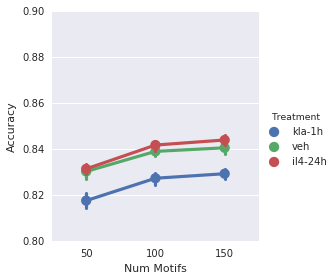

In [64]:
sns.factorplot(data = performance_frame, x = 'Num Motifs', y='Accuracy', hue = 'Treatment')
plt.ylim(0.8,0.9)

(0.8, 0.9)

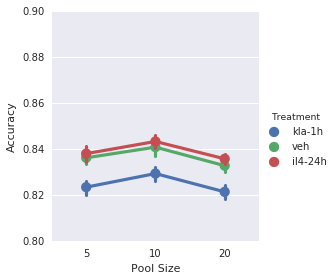

In [63]:
sns.factorplot(data = performance_frame, x = 'Pool Size', y='Accuracy', hue = 'Treatment')
plt.ylim(0.8,0.9)

(0.8, 0.9)

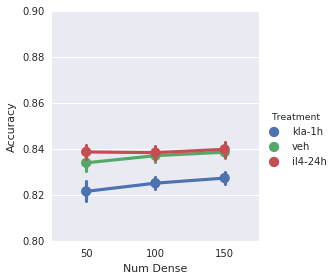

In [62]:
sns.factorplot(data = performance_frame, x = 'Num Dense', y='Accuracy', hue = 'Treatment')
plt.ylim(0.8,0.9)

## Weight Extraction

In [128]:
def get_sequence_attention(model, sequence, adjacent_bp_pool_size):
    get_attention = K.function([model.get_layer('input_fwd').input, 
                                model.get_layer('input_rev').input,
                                K.learning_phase()
                               ], 
                               [model.get_layer('attention_softmax_layer').output])
    fwd_seq = sequence[:200]
    rev_seq = str(Bio.Seq.Seq(fwd_seq).reverse_complement())
    
    fwd_seq_array = convert_sequences_to_array([fwd_seq])[0]
    rev_seq_array = convert_sequences_to_array([rev_seq])[0]

    layer_output = get_attention(([fwd_seq_array], [rev_seq_array], 0))[0]
    reshaped_output = layer_output.reshape((layer_output.shape[1], layer_output.shape[2]))


    full_attention = []
    for x in reshaped_output:
        for i in range(adjacent_bp_pool_size):
            full_attention.append(x)
    full_attention = np.array(full_attention)

    crop_distance = int((len(fwd_seq) - full_attention.shape[0])/2)

    attended_sequence = fwd_seq[crop_distance:-crop_distance]
    return layer_output, full_attention, attended_sequence

In [ ]:
layer_output, full_attention, attended_sequence = get_sequence_attention(dotProductAttention_model,
                                                                         str(positive_seqRecords[100].seq),
                                                                         10)

In [53]:
full_attention.shape

(150, 15)

In [54]:
attended_sequence

'AGACGCCTCCTAGGGCCGAAACCTCACCTCCCTTTGCCCGCCTGTTCCCTATGCATCTTGGAAATCGTAGTCCTCTGTAAACCAGCTGCTGAGGCGAGCGCCTCTAGTGTACTACAAGTCCCAGGATTCCATGCATCCGCAGGGCCTTAG'

In [55]:
chunks = []
for i in range(0,len(attended_sequence),10):
#     print(i, i+5, attended_sequence[i:i+5])
    chunks.append(attended_sequence[i:i+10])

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]), <a list of 15 Text yticklabel objects>)

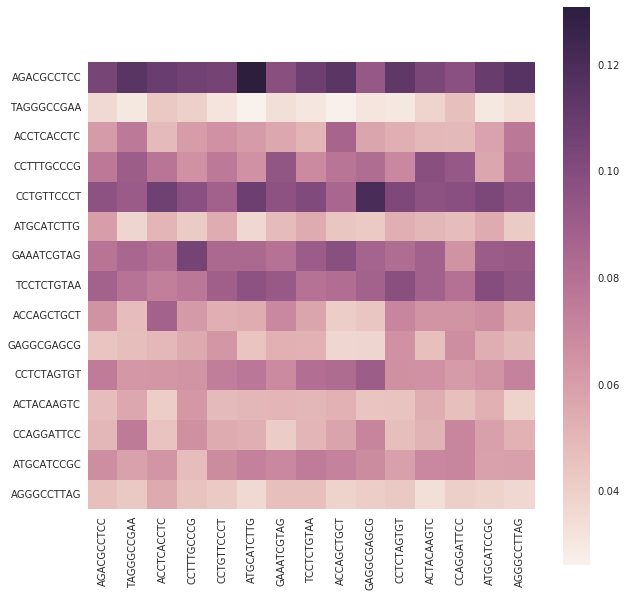

In [56]:
plt.figure(figsize = (10,10))
sns.heatmap(layer_output.reshape(layer_output.shape[1], 
                                 layer_output.shape[2]), 
    square = True,
    yticklabels = chunks,
    xticklabels=chunks)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)

In [39]:
summed_attention = layer_output.reshape(layer_output.shape[1], 
                                 layer_output.shape[2]).sum(axis=1)

In [40]:
summed_attention = summed_attention.reshape((len(summed_attention),1))

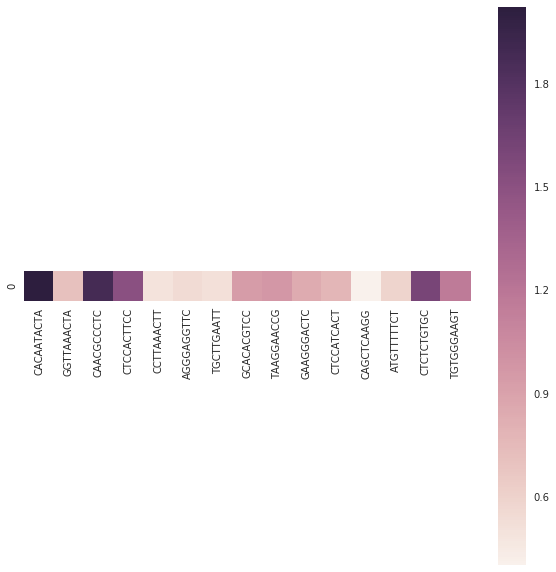

In [41]:
plt.figure(figsize = (10,10))


sns.heatmap(summed_attention.T,
            square = True,
            xticklabels=chunks)